## Fine-Tuning ResNet-50 on HMDB51

After building and training two custom models (3D CNN) — I’m now moving into the final benchmarking phase of my HMDB51 project. In this step, I’m fine-tuning a **pretrained ResNet-50** on my action recognition dataset to serve as a performance baseline.

Why am I doing this?

- To **compare** my scratch-built models with a powerful pretrained architecture.
- To **measure the value of transfer learning** on a relatively small video dataset like HMDB51, because technically speaking this is what is happening these days, that you have to use the pretrained models and fine tune based on the needs.
- To **see where my models stand** in terms of generalisation and robustness compared to a top-notch model like ResNet-50.

ResNet-50 was originally trained on ImageNet, so I’ll be adjusting (fine-tuning) it to fit the 51 action classes in HMDB51 using 2D frame-based inputs. The idea is simple: keep the earlier layers (which already understand general visual patterns), and retrain the final layers to recognise my specific action classes.

This final experiment will wrap up my comparative study between:
- My **custom 3D CNN models**
- A **fine-tuned ResNet-50**


## Step 1: Mounting Google Drive & Extracting Dataset

In this step, I’m setting up my workspace in **Google Colab** by doing the following


In [ ]:
from google.colab import drive
import zipfile
import os

# Mount Google Drive
drive.mount('/content/drive')

# my paths
zip_path_frames = "/content/drive/MyDrive/HMDB51/frames.zip"
zip_path_splits = "/content/drive/MyDrive/HMDB51/test_train_splits.zip"
extract_path = "/content/HMDB51"

# unzip both datasets
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path_frames, 'r') as zip_ref:
    zip_ref.extractall(f"{extract_path}/frames")

with zipfile.ZipFile(zip_path_splits, 'r') as zip_ref:
    zip_ref.extractall(f"{extract_path}/splits")

print("✅ All zipped files extracted.")


Mounted at /content/drive
✅ All zipped files extracted.


## Step 2: Parsing the Official HMDB51 Split Files

In this step, I’m parsing the official **train/test split files** for HMDB51 to build a clean mapping of video folders per class. These splits are crucial for maintaining consistency with the benchmark setup used in literature.

The HMDB51 dataset doesn’t come pre-sorted into "train" and "test" folders. These split files are **the ground truth** for training and evaluating models correctly. I’m building my own mapping so that later, when I load frames, I’ll know whether each belongs to training or testing — and what class it represents.

I’ve got 51 action classes total. As the previous models I used the same metadata (split1) by the curator of the dataset, which is 1=training, 2=test and 0=ignore

In [ ]:
import os
from pathlib import Path
from collections import defaultdict

splits_dir = Path("/content/HMDB51/splits/test_train_splits")
frames_root = Path("/content/HMDB51/frames/frames")

# creating train/test mapping dictionaries
train_split = defaultdict(list)
test_split = defaultdict(list)

for txt_file in sorted(splits_dir.glob("*_test_split1.txt")):
    class_name = txt_file.stem.replace("_test_split1", "")

    with open(txt_file, "r") as f:
        lines = f.readlines()

    for line in lines:
        video_name, split_id = line.strip().split()
        video_folder = video_name.replace(".avi", "")
        split_id = int(split_id)

        if split_id == 1:
            train_split[class_name].append(video_folder)
        elif split_id == 2:
            test_split[class_name].append(video_folder)

print(f"✅ Parsed splits: {len(train_split)} classes.")
print(f"🎬 Example class: '{list(train_split.keys())[0]}' - Train videos: {len(train_split[list(train_split.keys())[0]])}")


✅ Parsed splits: 51 classes.
🎬 Example class: 'brush_hair' - Train videos: 70


## Step 3: Custom Dataset Class for Frame Sequences

Now I’ve defined a `VideoFrameDataset` — a subclass of `torch.utils.data.Dataset`. It loads 16 consecutive frames per video and applies appropriate augmentations, preparing the data for training or evaluation.


| Component                | Description |
|----------------------------|----------------|
| `__init__` method          | I initialise the dataset with: <br> - a split dictionary (train or test), <br> - a `class_to_idx` mapping, <br> - a mode flag (`'train'` or `'test'`). <br><br>Then I flatten the split dictionary into a list of `(class_name, video_name)` tuples. |
| `_get_transform()`         | I define two sets of transformations: <br> - For training: Resizing, random crop, horizontal flip, colour jitter, and standard ImageNet normalisation. <br> - For testing: Simple resize and normalisation. |
| `__len__()`                | Returns the total number of video samples. |
| `__getitem__()`            | For each video sample: <br> - I locate the 16 frame images, <br> - Apply transformations to each frame, <br> - Stack them into a tensor of shape , <br> - And return the video tensor along with its numeric class label. |




In [ ]:
from torch.utils.data import Dataset
from PIL import Image
import torch
import torchvision.transforms as T

class VideoFrameDataset(Dataset):
    def __init__(self, data_split_dict, class_to_idx, frames_root, mode='train'):
        self.samples = []
        self.class_to_idx = class_to_idx
        self.frames_root = frames_root
        self.mode = mode

        for class_name, video_list in data_split_dict.items():
            for video_name in video_list:
                self.samples.append((class_name, video_name))

        self.transform = self._get_transform()

    def _get_transform(self):
        if self.mode == 'train':
            return T.Compose([
                T.Resize((256, 256)),
                T.RandomCrop(224),
                T.RandomHorizontalFlip(),
                T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                T.ToTensor(),
                T.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
            ])
        else:
            return T.Compose([
                T.Resize((224, 224)),
                T.ToTensor(),
                T.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
            ])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        class_name, video_name = self.samples[idx]
        label = self.class_to_idx[class_name]

        frame_folder = self.frames_root / class_name / video_name
        frame_paths = sorted(frame_folder.glob("*.jpg"))[:16]  # the frames are like 0000.jpg to 0015.jpg (16 in total)

        frames = [self.transform(Image.open(fp).convert("RGB")) for fp in frame_paths]
        video_tensor = torch.stack(frames, dim=1)  # Shape: [C, T, H, W]

        return video_tensor, label


## Step 4: Defining `class_to_idx` Mapping

Here, I’m generating a **dictionary that maps each class name to a unique index** — this is crucial for converting string labels into numeric values that can be used as targets in training.


| Operation                     | Explanation |
|----------------------------------|----------------|
| `sorted(list(train_split.keys()))` | I collect all class names from the training split and sort them alphabetically for consistency. |
| `enumerate(...)`                | I pair each class name with a unique integer index — this becomes the mapping. |
| `class_to_idx`                 | A dictionary like `{'brush_hair': 0, 'cartwheel': 1, ..., 'wave': 50}`. |
| `num_classes`                  | I compute the total number of action classes (Just to check that everything is going smoothly) — which should be **51** for HMDB51. |

This mapping gets passed into the dataset and ensures that every frame sequence is labelled with a consistent integer ID. Without it, PyTorch wouldn't know what im trying to classify!

---


In [ ]:
# class_to_idx: {'brush_hair': 0, 'cartwheel': 1, ..., 'wave': 50}
all_classes = sorted(list(train_split.keys()))
class_to_idx = {cls_name: idx for idx, cls_name in enumerate(all_classes)}
num_classes = len(class_to_idx)
print(f"🔢 Number of classes: {num_classes}")


🔢 Number of classes: 51


## Step 5: Fine-Tuning ResNet-50 for Action Recognition

Now stepping into the final phase of my HMDB51 pipeline: fine-tuning a **pretrained ResNet-50** model. Unlike the previous custom CNNs, this one uses **transfer learning** — bringing in the heavyweight features learned from **ImageNet** and adapting them to action recognition using extracted video frames.

---

### fine-tuning

I'm keeping the entire feature extractor (Conv1 through Layer4) and just swap out the classifier layer (which originally mapped to 1000 ImageNet classes) with a new one mapping to my 51 HMDB51 actions.

Here’s what’s happening:

| Line | Code | Purpose |
|------|------|---------|
| `B, C, T, H, W = x.size()` | Unpacks input tensor shape | my input tensor is shaped `[B, C, T, H, W]`, i.e., a video batch with `T` frames per clip |
| `x = x.permute(0, 2, 1, 3, 4)` | Reorders dimensions | Swaps to `[B, T, C, H, W]`, so time steps come first — easier to flatten per-frame |
| `x = x.reshape(B * T, C, H, W)` | Flattens time dimension into batch | Now it looks like a batch of images: `[B*T, C, H, W]` — ready for ResNet! |
| `logits = self.backbone(x)` | Runs through ResNet-50 | Applies pretrained ResNet-50 frame by frame |
| `logits = logits.view(B, T, -1)` | Reshapes back to video clip | Collects logits back into `[B, T, num_classes]` — one prediction per frame |
| `logits = logits.mean(dim=1)` | Temporal averaging | Averages logits across time dimension T to get final prediction per video |
| `return logits` | Final prediction | Output shape `[B, num_classes]`, ready for softmax/loss |

---

### What's Going On

| Section | Purpose |
|--------|----------|
| `ResNet50TemporalAvg` | A custom wrapper that allows the 2D ResNet-50 to handle video input by temporally averaging frame logits. |
| Temporal Pooling | After passing each frame independently through ResNet-50, we average predictions over time to get the final action class. |
| Final Layer Replacement | The original `fc` layer (1000 classes for ImageNet) is replaced with a fresh `Linear(..., 51)` layer for the HMDB51 dataset. |
| Train/Val/Test Loaders | DataLoaders are created from the extracted frames using balanced class-wise splits. |
| Batch Size | Limited to **8** due to Colab GPU constraints (my attempts at 16 and 64 hit memory issues). |

---

### What is Transfer Learning?

Transfer learning is a strategy where a model pretrained on a large dataset (like ImageNet) is **reused** — either fully or partially — on a new task. Here's how it's applied in this project:

- The **ResNet-50 backbone** comes pretrained on ImageNet.
- We retain the **weights of all layers**, but **replace the classifier head** (final fully-connected layer).
- All layers are **kept trainable** (i.e., we’re doing **fine-tuning** not feature extraction), allowing the model to adapt both low-level and high-level features to the HMDB51 video frames.

---

### ResNet-50 Architecture Breakdown

Here’s a complete breakdown of the **ResNet-50 architecture**, summarising the purpose of each key component. This architecture is originally introduced by [He et al., 2016](https://arxiv.org/abs/1512.03385).

| Layer Name     | Output Shape         | Components                                                  | Description |
|----------------|----------------------|-------------------------------------------------------------|-------------|
| **Conv1**      | [B, 64, 112, 112]     | 7×7 conv, 64 filters, stride=2                              | Initial convolution to reduce spatial size and extract basic features |
| **MaxPool**    | [B, 64, 56, 56]       | 3×3 max pooling, stride=2                                   | Reduces spatial resolution, keeps strong activations |
| **Layer1**     | [B, 256, 56, 56]      | 3 bottleneck blocks: 1×1, 3×3, 1×1 conv (64 → 64 → 256)     | Early residual features with skip connections |
| **Layer2**     | [B, 512, 28, 28]      | 4 bottleneck blocks (128 → 128 → 512)                       | Mid-level features, more abstract |
| **Layer3**     | [B, 1024, 14, 14]     | 6 bottleneck blocks (256 → 256 → 1024)                      | High-level representations |
| **Layer4**     | [B, 2048, 7, 7]       | 3 bottleneck blocks (512 → 512 → 2048)                      | Final feature maps before classification |
| **AvgPool**    | [B, 2048]             | Global average pooling                                      | Aggregates spatial features into vector form |
| **FC (replaced)** | [B, 51]            | Linear(2048 → 51)                                           | Final classification layer adapted to HMDB51 |

> **Note:** In `ResNet50TemporalAvg`, this model is applied frame-by-frame across a video clip of 16 frames, then predictions are averaged across time (temporal pooling) to infer the action.

---

### Transfer Learning Strategy

- **Pretrained Weights**: Loaded from ImageNet.
- **Classifier Head**: Fully replaced with a new layer tailored to HMDB51 (51 action classes).


In [ ]:
import torch.nn as nn
import torchvision.models as models

class ResNet50TemporalAvg(nn.Module):
    def __init__(self, num_classes=51, pretrained=True):
        super().__init__()
        self.backbone = models.resnet50(pretrained=pretrained)

        # replacing final FC, just a quick segway, im keeping the entire feature extractor (Conv1 through Layer4)
        # and just swap out the classifier layer (which originally mapped to 1000 ImageNet classes) with
        # a new one mapping to my 51 HMDB51 actions.
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, num_classes)

    def forward(self, x):  # x shape: [B, C, T, H, W]
        B, C, T, H, W = x.size()
        x = x.permute(0, 2, 1, 3, 4)  # → [B, T, C, H, W]
        x = x.reshape(B * T, C, H, W)  # → [B*T, C, H, W]

        logits = self.backbone(x)  # → [B*T, num_classes]
        logits = logits.view(B, T, -1)  # → [B, T, num_classes]

        logits = logits.mean(dim=1)  # average over T → [B, num_classes]
        return logits
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResNet50TemporalAvg(num_classes=num_classes, pretrained=True)
model = model.to(device)

import random
from collections import defaultdict

train_split_new = defaultdict(list)
val_split_new = defaultdict(list)

val_ratio = 0.1
random.seed(42)

for cls, video_list in train_split.items():
    random.shuffle(video_list)
    split_idx = int(len(video_list) * (1 - val_ratio))
    train_split_new[cls] = video_list[:split_idx]
    val_split_new[cls] = video_list[split_idx:]

print(f"✅ Sample class: {list(train_split_new.keys())[0]} - Train: {len(train_split_new[list(train_split_new.keys())[0]])}, Val: {len(val_split_new[list(val_split_new.keys())[0]])}")

frames_root = Path("/content/HMDB51/frames/frames")

train_dataset = VideoFrameDataset(train_split_new, class_to_idx, frames_root, mode='train')
val_dataset = VideoFrameDataset(val_split_new, class_to_idx, frames_root, mode='val')
test_dataset = VideoFrameDataset(test_split, class_to_idx, frames_root, mode='val')  # 'val' mode disables augmentation

from torch.utils.data import DataLoader

batch_size = 8 # weirdly i keep this message that gpu memory slap, and its better to use 16 instead of 64 and then again got the same mesage, so id try 8
num_workers = 2  # Can increase if Colab allows, which it does NOT

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 134MB/s]


✅ Sample class: brush_hair - Train: 63, Val: 7


## Training Loop Explanation

This is my full training pipeline, with some features:
- Early stopping (to prevent overfitting), *lemme be more specific of what has happened to me, so basically when i start the training i started with 30 epochs and early stopping with patience 10, but as I you can see on the screen shot by 10th epochs i got the pop-up from colab that you exceed the free plan, as I noticed that on epoch 10 I actually got to ag good level of acc and loss, so for this time I put 10 as epochs and patience 5 (just to be there)*

- Learning rate scheduling. In my training loop, I use `ReduceLROnPlateau` as a learning rate scheduler to make my optimiser smarter. Instead of keeping the learning rate fixed, I allow it to adapt based on the validation loss, if the loss doesn't improve for 3 consecutive epochs (`patience=3`), the scheduler reduces the learning rate by half (`factor=0.5`). This is triggered in `'min'` mode, meaning it looks for drops in the validation loss. I call `scheduler.step(epoch_val_loss)` after each validation phase to pass in the latest loss and let the scheduler decide. This helps me fine-tune the learning rate during training, taking larger steps early on and smaller, more precise steps as convergence slows — which improves overall model performance and stability, especially when paired with early stopping.

- Model checkpoint saving

- Accuracy/loss tracking for both training and validation so I can use it later on for analysis of the model

### Components

| Component | Purpose |
|----------|---------|
| `nn.CrossEntropyLoss()` | Standard loss for multi-class classification |
| `optim.Adam(model.parameters(), lr=1e-4)` | Adam optimiser, good default for most deep learning tasks |
| `ReduceLROnPlateau` | Reduces LR when validation loss plateaus |
| `EarlyStopping` | Stops training if val loss doesn't improve after `patience` epochs |
| `best_model.pth` | File where best performing model (on val acc) is saved |

---

### What Happens Each Epoch?

1. **Training Phase**
    - Model in `.train()` mode (activates dropout/batchnorm).
    - Zero gradients → forward pass → compute loss → backward pass → update weights.
    - Accumulate running loss and correct predictions to compute epoch metrics.

2. **Validation Phase**
    - Model in `.eval()` mode (turns off dropout/batchnorm updates).
    - Forward pass without gradient tracking.
    - Accumulate val loss and correct predictions for metrics.

3. **Metrics & Logging**
    - Accuracy and average loss printed each epoch.
    - `ReduceLROnPlateau` monitors val loss and halves LR if needed.
    - If current val accuracy is the best so far, model is saved to disk.
    - Early stopping monitors validation loss and stops training if no improvement for `patience` epochs.

4. **Final Step**
    - Best model (by val accuracy) is reloaded from disk at the end.

---

### `history` Dictionary

Stored training history for plotting later:

| Key | Description |
|-----|-------------|
| `train_loss` | List of training loss values per epoch |
| `val_loss` | List of validation loss values per epoch |
| `train_acc` | Training accuracy per epoch |
| `val_acc` | Validation accuracy per epoch |

---



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import os

# Loss and optimiser and schedualr
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Early stopping
class EarlyStopping:
    def __init__(self, patience=8):
        self.patience = patience
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Main training loop
def train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler,
    num_epochs=10, patience=5, device='cuda', best_model_path='best_model.pth'
):
    early_stopper = EarlyStopping(patience=patience)
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': []
    }

    best_val_acc = 0.0

    for epoch in range(num_epochs):
        print(f"\n📆 Epoch {epoch+1}/{num_epochs}")

        # ----- Training is happening here -----
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for clips, labels in tqdm(train_loader, desc="🟢 Training", leave=False):
            clips, labels = clips.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(clips)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * clips.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        epoch_train_loss = running_loss / total
        epoch_train_acc = correct / total

        # ----- Validation is happening here -----
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0

        with torch.no_grad():
            for clips, labels in tqdm(val_loader, desc="🔵 Validation", leave=False):
                clips, labels = clips.to(device), labels.to(device)
                outputs = model(clips)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * clips.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        epoch_val_loss = val_loss / val_total
        epoch_val_acc = val_correct / val_total

        # logging
        print(f"📊 Train Loss: {epoch_train_loss:.4f}, Acc: {epoch_train_acc:.4f} | Val Loss: {epoch_val_loss:.4f}, Acc: {epoch_val_acc:.4f}")

        history['train_loss'].append(epoch_train_loss)
        history['val_loss'].append(epoch_val_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_acc'].append(epoch_val_acc)

        # Scheduler step
        scheduler.step(epoch_val_loss)

        # Save best model to my colab content
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            torch.save(model.state_dict(), best_model_path)
            print(f"💾 Best model saved at epoch {epoch+1} with val acc {best_val_acc:.4f}")

        # Early stopping
        early_stopper(epoch_val_loss)
        if early_stopper.early_stop:
            print("🛑 Early stopping triggered!")
            break

    # Load best model
    if os.path.exists(best_model_path):
        print(f"✅ Loading best model from {best_model_path}")
        model.load_state_dict(torch.load(best_model_path, map_location=device))

    return model, history


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


### Let's run it, but before that I wanna share something with you:

I originally set the model to train for 30 epochs, but around epoch 11, Colab crashed, as you can see in the screenshot. It flagged that I'd used up too much computation and
hit the limit of the free plan.

<img src="/Users/alesarabandi/Downloads/DEEPLEARING/project/Screenshot 2025-06-17 at 18.03.52.png" width="600">


That first run didn’t quite go to plan, but it showed that the model was already performing really well by epoch 10. So I decided to cap it there instead. Realistically, even if I hadn’t run into that issue, I wouldn’t have been able to go much further due to the same resource limits.
The patience setting is still in the code, but it doesn’t really do anything at this point since early stopping isn’t actually enabled.

In [ ]:
model, history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=10, # I ran it with 30 epochs but at the epoch 11 my colab
                   #collapsed as it said too much calculation, you ran of your free plan!
                   # so based on this kinda failed attempt I noticed I get a very good result
                  #with 10 epochs, so i change it to 10. tbh even if that wasnt the case I couldnt do much about it
                   #with that been said, the patience is just there its not gonna plug early-stop in
    patience=5,
    device=device
)



📆 Epoch 1/10


📊 Train Loss: 2.6617, Acc: 0.3352 | Val Loss: 1.7025, Acc: 0.5126
💾 Best model saved at epoch 1 with val acc 0.5126

📆 Epoch 2/10


📊 Train Loss: 1.6075, Acc: 0.5702 | Val Loss: 1.4219, Acc: 0.5910
💾 Best model saved at epoch 2 with val acc 0.5910

📆 Epoch 3/10


📊 Train Loss: 1.1734, Acc: 0.6928 | Val Loss: 1.4452, Acc: 0.6359
💾 Best model saved at epoch 3 with val acc 0.6359

📆 Epoch 4/10


📊 Train Loss: 0.9314, Acc: 0.7426 | Val Loss: 1.2352, Acc: 0.6807
💾 Best model saved at epoch 4 with val acc 0.6807

📆 Epoch 5/10


📊 Train Loss: 0.7142, Acc: 0.8042 | Val Loss: 1.2163, Acc: 0.6807

📆 Epoch 6/10


📊 Train Loss: 0.5537, Acc: 0.8466 | Val Loss: 1.3495, Acc: 0.6555

📆 Epoch 7/10


📊 Train Loss: 0.4457, Acc: 0.8824 | Val Loss: 1.2913, Acc: 0.6807

📆 Epoch 8/10


📊 Train Loss: 0.3744, Acc: 0.9023 | Val Loss: 1.3393, Acc: 0.6835
💾 Best model saved at epoch 8 with val acc 0.6835

📆 Epoch 9/10


📊 Train Loss: 0.3153, Acc: 0.9178 | Val Loss: 1.2131, Acc: 0.7339
💾 Best model saved at epoch 9 with val acc 0.7339

📆 Epoch 10/10


📊 Train Loss: 0.2600, Acc: 0.9300 | Val Loss: 1.2083, Acc: 0.7115
✅ Loading best model from best_model.pth


## Model Training Analysis

So overall, the model’s learning pretty well. Training accuracy’s gone up nicely, loss has come down, and validation performance peaked around **epoch 9**—which is when I saved the model.

---

### Loss Curve Observations

- **Training Loss** kept dropping consistently from **2.66 down to 0.26**. Happy days—model’s learning the training data without a fuss.
- **Validation Loss** dipped till about **epoch 4–5**, then started getting a bit shaky, hovering between **1.2 and 1.3**.
---

### Accuracy Curve Observations

- **Training Accuracy** climbed from **33.5% up to 93%**—textbook learning behaviour.
- **Validation Accuracy** moved up from **51% to 73%** by **epoch 9**, though the improvement slowed after epoch 6. Still, the validation accuracy peaked at 73%, so I knew that’s where to call it.

Even though the val loss didn’t improve much after epoch 5, the accuracy still did. That’s normal—accuracy can rise while the model just gets more confident (even if sometimes wrongly so).

---

### Overfitting? Yeah, but It’s in Range

There’s definitely overfitting kicking in around epoch 6:
- The gap between train and val accuracy becomes big (e.g. 88% vs. 68%).
- Training loss keeps falling, while val loss stops improving.
- Validation metrics wobble a bit.

But here’s the thing, it’s **within a reasonable range**. With a dataset like HMDB51 (relatively small, high intra-class variance), a bit of overfitting is to be expected. I'm not seeing catastrophic divergence here, just the usual gap when the model’s getting a bit too cosy with the training data.

---

### Why I Picked Epoch 9

- **Best Validation Accuracy** at epoch 9: **73.39%**
- **Lowest Val Loss** also very close at that point: **1.2131**
- Epoch 10’s val loss dipped slightly more, but accuracy dropped—so I stuck with **epoch 9**.

Basically, the model had its best generalisation then.

---


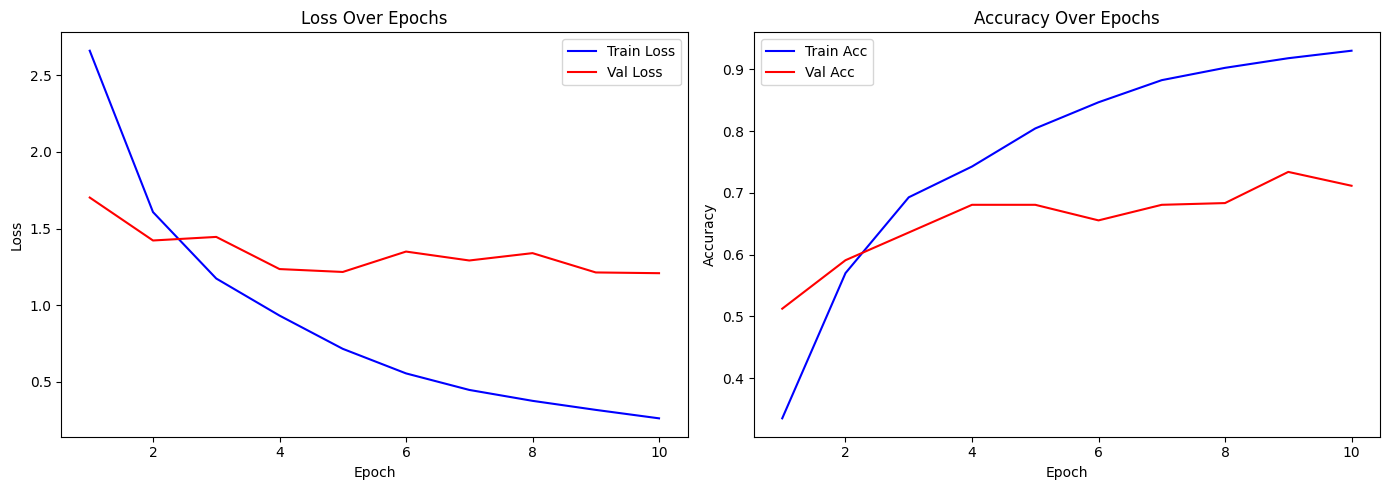

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(14, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'b-', label='Train Loss')
    plt.plot(epochs, history['val_loss'], 'r-', label='Val Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], 'b-', label='Train Acc')
    plt.plot(epochs, history['val_acc'], 'r-', label='Val Acc')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)


### Sanity Check: Model Parameter Count (ResNet-50)

I forgot to print the model summary earlier. Luckily, I’d already saved the `.pth` weights (If i wanna highlight one of the many things that I learned from this projects and its challenges, that would be "ALWAYS SAVE YOUR STUFF" eventhough you might think that it wont be useful later. Lemme tell you something, been there done that and ended up with regret), so I just rebuilt the model architecture, loaded the weights, and dodged the whole retraining palaver.

I expect to have around 23.6 million parameter, here’s why:

---

####  Base ResNet-50:
The standard ResNet-50, as used for ImageNet, comes with about **25.56 million parameters**. That includes the original fully connected (fc) layer which maps to 1000 output classes, and that alone accounts for roughly **2.05 million** of the total.

---

####  Custom Final Layer:
I replaced the original fc layer with one that maps to just **51 output classes**, which drastically reduces the number of parameters in that layer — down to roughly **104,500**.

---

####  Total Adjustment:
So, removing the original fc layer and adding mine gives:

- 25.56M (original total)
- minus 2.05M (old fc layer)
- plus 104.5K (new fc layer)

That brings the total to around **23.61 million parameters**.

---

####  Final Count:
As you can see on the output table, the final model has about **23.6M parameters**, which is exactly what I expected.


In [ ]:
import torch
import torch.nn as nn
from torchvision import models
from torchsummary import summary
from google.colab import drive

drive.mount('/content/drive')

# define the model architecture again exactly like before cuz im running after i built the model and train it
class ResNet50TemporalAvg(nn.Module):
    def __init__(self, num_classes=51, pretrained=False):
        super().__init__()
        self.backbone = models.resnet50(pretrained=pretrained)
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, num_classes)

    def forward(self, x): 
        B, C, T, H, W = x.size()
        x = x.permute(0, 2, 1, 3, 4)  
        x = x.reshape(B * T, C, H, W) 
        logits = self.backbone(x) 
        logits = logits.view(B, T, -1)  
        return logits.mean(dim=1) 


model = ResNet50TemporalAvg(num_classes=51, pretrained=False).to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/best_model_RESNET50.pth", map_location=device))

summary(model, input_size=(3, 16, 224, 224), device=str(device))


Mounted at /content/drive


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

## Top accuracy

- `evaluate_topk` Function Breakdown

| Line of Code                                                                 | What It Does                                                                                       | Why It Matters                                                                                 |
|------------------------------------------------------------------------------|----------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------|
| `model.eval()`                                                               | Sets the model to evaluation mode.                                                                 | Turns off dropout, batch norm behaves deterministically — essential for inference.            |
| `with torch.no_grad():`                                                     | Disables gradient calculation.                                                                     | Saves memory and speeds up inference — we don't need gradients when not training.             |
| `for clips, labels in test_loader:`                                         | Iterates over the test dataset in batches.                                                         | Allows batch-wise evaluation of the model.                                                    |
| `clips, labels = clips.to(device), labels.to(device)`                       | Moves data to GPU or CPU as specified.                                                             | Ensures data is on the same device as the model.                                              |
| `outputs = model(clips)`                                                    | Runs a forward pass through the model.                                                             | Produces raw prediction scores (logits).                                                      |
| `probs = F.softmax(outputs, dim=1)`                                         | Converts logits to probabilities across classes.                                                   | Needed for ranking predictions — turns raw scores into interpretable probabilities.           |
| `topk_preds = probs.topk(k, dim=1).indices`                                 | Gets the indices of the top-k predicted classes for each sample.                                   | Tells us the model’s k best guesses — useful for top-k evaluation.                            |
| `(topk_preds == labels.unsqueeze(1)).sum().item()`                          | Compares top-k guesses with the ground truth, sums up correct guesses.                            | Counts how many times the true label is within the top-k predictions.                         |
| `correct_topk[i] += ...`                                                    | Adds the number of correct predictions to a running total.                                         | Accumulates results for final accuracy calculation.                                            |
| `total += labels.size(0)`                                                   | Keeps track of the number of samples evaluated.                                                    | Needed to normalise the number of correct predictions into an accuracy.                       |
| `acc = correct_topk[i] / total`                                             | Calculates Top-k accuracy.                                                                         | Gives the percentage of correct predictions at each k level.                                  |
| `print(f" Top-{k} Accuracy: {acc:.4f}")`                                   | Nicely prints the Top-k accuracy.                                                                  | Helps me judge how well my model ranks predictions — especially when classes look similar.    |

---
To wrap up my model evaluation, I implemented **Top-k Accuracy** to see not just if my model got the prediction right. In the `evaluate_topk` function, I loop through the test set, grab the model outputs, and apply a `softmax` to turn raw logits into probabilities. Then I use `topk` to fetch the top-k most likely classes for each sample — think of it as asking the model: “If you had to guess 5 times, would you get it right?”

For each k (Top-1, Top-2, Top-5), I check whether the true label is in those guesses and keep count. Once it’s done combing through the whole dataset, I divide the correct guesses by the total to get the accuracy for each top-k level. And here’s the good stuff:

- **Top-1 Accuracy**: `43.27%` – solid, considering the 51 classes!
- **Top-2 Accuracy**: `56.21%` – more than half the time it’s in the top 2!
- **Top-5 Accuracy**: `75.10%` – now we’re talking, three out of four right in the top 5!

This gives me a much clearer view of how well the model’s actually ranking actions, especially when classes are visually similar. It's not just about being perfect — it's about being consistently close.


In [ ]:
import torch.nn.functional as F

def evaluate_topk(model, test_loader, label_encoder, device='cuda', topk=(1, 2, 5)):
    model.eval()
    correct_topk = [0] * len(topk)
    total = 0

    with torch.no_grad():
        for clips, labels in test_loader:
            clips, labels = clips.to(device), labels.to(device)
            outputs = model(clips)
            probs = F.softmax(outputs, dim=1)

            for i, k in enumerate(topk):
                topk_preds = probs.topk(k, dim=1).indices
                correct_topk[i] += (topk_preds == labels.unsqueeze(1)).sum().item()

            total += labels.size(0)

    for i, k in enumerate(topk):
        acc = correct_topk[i] / total
        print(f"🎯 Top-{k} Accuracy: {acc:.4f}")

evaluate_topk(model, test_loader, label_encoder)


🎯 Top-1 Accuracy: 0.4327
🎯 Top-2 Accuracy: 0.5621
🎯 Top-5 Accuracy: 0.7510


### Per-Class Accuracy Analysis — My Breakdown

To diagnose where my model rock and where it's struggling, the `compute_per_class_accuracy()` function uses the folder names from my HMDB51 frame dataset (I explained the structure of my dataset on file number 3) as class labels. Below is what each part of the function does and why it matters:

| Code Snippet |  What It Does |
|----------------|------------------|
| `class_names = sorted([...])` | Grabs all the class names from the directory structure (like "drink", "kick").
| `model.eval()` | Switches model to evaluation mode.
| `class_correct = defaultdict(int)`<br>`class_total = defaultdict(int)` | Sets up counters to track correct predictions and total samples per class.
| `with torch.no_grad():` | Turns off gradient tracking, this speeds up inference and saves memory.
| `for clips, labels in test_loader:` | Iterates through batches from the test set.
| `outputs = model(clips)` | Gets raw logits for each clip.
| `preds = outputs.argmax(dim=1)` | Converts logits to predicted class indices.
| `for label, pred in zip(labels, preds):`<br>`class_name = class_names[label.item()]` | Loops through predictions and maps labels to class names.
| `if label.item() == pred.item(): ...` | Compares predictions to ground truth.
| `print(f"{cls:25s} | Accuracy: {acc:.2f}%")` | Nicely prints results per class.

---

### Output Highlights:

| Class Name | Accuracy |
|--------------|------------|
| `ride_bike`  | 96.67%  — Nailed it! |
| `push`       | 86.67% — Solid recognition. |
| `hug`        | 83.33% — Warm and accurate. |
| `fall_floor` | 3.33% — We’ve got some serious confusion here... |
| `wave`       | 3.33% — Either it looks too similar to others, or the model’s just not feeling social. |

This kind of per-class breakdown helps me see beyond the overall accuracy — it highlights exactly where the model performs well and which actions it struggles to distinguish. Especially useful for action classes that have visual overlaps (like `kick` vs `kick_ball` or `run` vs `walk` or `push` vs `pushup` you name ot ).



In [ ]:
import os
from collections import defaultdict
import torch

def compute_per_class_accuracy(model, test_loader, data_path, device='cuda'):

    # getting class names from the folder structure
    class_names = sorted([f for f in os.listdir(data_path) if not f.startswith('.')])

    # Set model to eval mode
    model.eval()
    class_correct = defaultdict(int)
    class_total = defaultdict(int)

    with torch.no_grad():
        for clips, labels in test_loader:
            clips = clips.to(device)
            labels = labels.to(device)
            outputs = model(clips)
            preds = outputs.argmax(dim=1)

            for label, pred in zip(labels, preds):
                class_name = class_names[label.item()]
                class_total[class_name] += 1
                if label.item() == pred.item():
                    class_correct[class_name] += 1

    # Print per-class accuracy
    print("🎯 Per-Class Accuracy Report\n" + "-"*40)
    for cls in class_names:
        correct = class_correct[cls]
        total = class_total[cls]
        acc = 100.0 * correct / total if total > 0 else 0.0
        print(f"{cls:25s} | Accuracy: {acc:.2f}%")


In [ ]:
data_path = "/content/HMDB51/frames/frames"

compute_per_class_accuracy(model, test_loader, data_path)


🎯 Per-Class Accuracy Report
----------------------------------------
brush_hair                | Accuracy: 46.67%
cartwheel                 | Accuracy: 6.67%
catch                     | Accuracy: 40.00%
chew                      | Accuracy: 76.67%
clap                      | Accuracy: 16.67%
climb                     | Accuracy: 66.67%
climb_stairs              | Accuracy: 33.33%
dive                      | Accuracy: 40.00%
draw_sword                | Accuracy: 60.00%
dribble                   | Accuracy: 66.67%
drink                     | Accuracy: 56.67%
eat                       | Accuracy: 53.33%
fall_floor                | Accuracy: 3.33%
fencing                   | Accuracy: 70.00%
flic_flac                 | Accuracy: 10.00%
golf                      | Accuracy: 73.33%
handstand                 | Accuracy: 66.67%
hit                       | Accuracy: 3.33%
hug                       | Accuracy: 83.33%
jump                      | Accuracy: 16.67%
kick                      | Accura

## Visualising Predictions: What’s the Model Actually Seeing?

Right, so here's the deal. I ran my `show_predictions_for_class_full` function on four different classes from the HMDB51 dataset — just to get a feel for how well my 3D CNN model's doing on real test samples. I wanted to **see the actual frames**, check the **top-5 predicted classes**, and compare them to the ground truth. Let’s break down the function first, then I’ll chat through the results.

---

### What the Function Does (`show_predictions_for_class_full`)

| Part of Code | What It's Doing |
|--------------|------------------|
| `model.eval()` | Switches the model to eval mode – turns off dropout and batchnorm updates. |
| `selected_samples` | Just a list to keep test clips that match the class I’m after (e.g. `kiss`). |
| `with torch.no_grad()` | Stops PyTorch from tracking gradients – speeds things up and saves memory during testing. |
| Looping over `test_loader` | Grabs batches from the test set, one batch at a time. |
| `if label.item() == target_idx` | Filters only those clips that match the class I want to look at. |
| `clip = clip.unsqueeze(0).to(device)` | Adds batch dimension and moves the clip to GPU or CPU. |
| `output = model(clip)` | Runs the clip through the model. |
| `probs = F.softmax(output, dim=1)` | Converts raw scores to probabilities. |
| `top5_probs, top5_idxs = probs.topk(5)` | Gets the top-5 predictions and their probabilities. |
| `frame = clip[0, :, clip.shape[2] // 2]` | Pulls the middle frame (so we see something representative). |
| `plt.imshow(...)` | Plots the frame with the ground truth label as title. |
| `print(...)` | Prints the top-5 class predictions and their probabilities. |

Basically, it's a quick way to **see what the model thinks** is happening in the video and whether it's getting it right.

---

### Why I Picked These Classes

I didn’t just pick classes at random — each one tells me something different about how the model’s performing.

| Class | Why I Picked It |
|-------|------------------|
| `brush_hair` | A small, subtle motion, not dramatic like jumping. If it gets this right, that’s impressive. |
| `kiss` | Very specific, I was curious whether the model could nail it or confuse it with something like hugging or any action that requires two people. |
| `walk` | Simple but can overlap with other stuff like standing, running, or sitting. |

---

### What Did the Model Actually Predict?

---

#### **Class: `brush_hair`**

- **Clip 1:** `brush_hair` (96.2%) 
- **Clip 2:** `brush_hair` (90.4%)

**Takeaway**: Bang on. Even with a subtle action like brushing your hair, the model’s confident. That’s a good sign that it’s learning fine motor patterns too.

---

#### **Class: `kiss`**

- **Clip 1:** `kiss` (100%)   
- **Clip 2:** `kiss` (99.7%)

**Takeaway**: Absolutely rocked it. Super confident, no confusion. Social interactions like this seem to have distinct visual cues the model’s picking up on, probably faces close together, consistent motion, two people involved.

---

#### **Class: `walk`**

- **Clip 1:** `walk` (70.2%) 
  - Bit of confusion with `sit` (13%) and `stand` (10.6%)
- **Clip 2:** `walk` (99.9%)

**Takeaway**: Generally spot-on, but some borderline confusion when the posture’s not super clear. Makes sense — walking transitions often start or end in standing/sitting, this is amazing and I kinda expect it as you might remember (if U go to EDA file) walk has the highest number of videos.

---


In [ ]:
def show_predictions_for_class_full(model, test_loader, target_class, index_to_label, label_to_index, device='cuda', num_samples=2):
    model.eval()
    selected_samples = []
    target_idx = label_to_index[target_class]

    with torch.no_grad():
        for clips, labels in test_loader:
            for clip, label in zip(clips, labels):
                if label.item() == target_idx:
                    selected_samples.append((clip, label))
                    if len(selected_samples) >= num_samples:
                        break
            if len(selected_samples) >= num_samples:
                break

    if not selected_samples:
        print(f"No samples of class '{target_class}' found in test set.")
        return

    for clip, label in selected_samples:
        clip = clip.unsqueeze(0).to(device)
        output = model(clip)
        probs = F.softmax(output, dim=1).squeeze()

        top5_probs, top5_idxs = probs.topk(5)
        top5_labels = [index_to_label[idx.item()] for idx in top5_idxs]
        gt_label = index_to_label[label.item()]

        # Show the middle frame
        frame = clip[0, :, clip.shape[2] // 2]
        frame = frame.permute(1, 2, 0).cpu().numpy()
        frame = (frame - frame.min()) / (frame.max() - frame.min())

        plt.figure(figsize=(4, 4))
        plt.imshow(frame)
        plt.axis('off')
        plt.title(f"🎯 GT: {gt_label}")
        plt.show()

        print("🔮 Top-5 predictions:")
        for lbl, prob in zip(top5_labels, top5_probs.detach().cpu().numpy()):
            print(f"{lbl:20s} | Prob: {prob:.4f}")
        print("-" * 40)


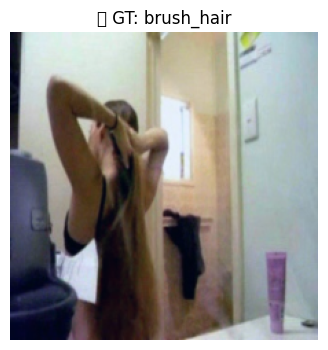

🔮 Top-5 predictions:
brush_hair           | Prob: 0.9615
chew                 | Prob: 0.0248
dive                 | Prob: 0.0067
jump                 | Prob: 0.0013
pick                 | Prob: 0.0006
----------------------------------------


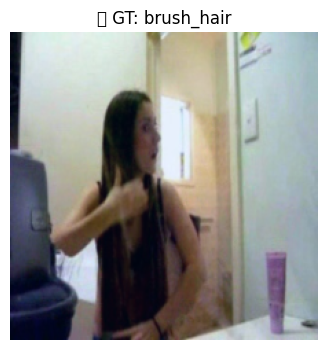

🔮 Top-5 predictions:
brush_hair           | Prob: 0.9040
chew                 | Prob: 0.0920
smoke                | Prob: 0.0009
clap                 | Prob: 0.0008
draw_sword           | Prob: 0.0007
----------------------------------------


In [ ]:
show_predictions_for_class_full(model, test_loader, target_class="brush_hair",
                                index_to_label=index_to_label, label_to_index=label_to_index)


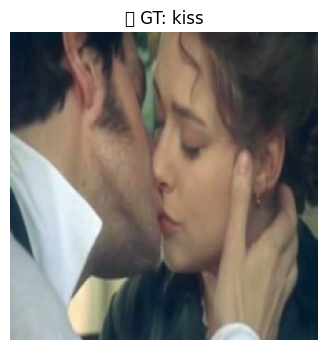

🔮 Top-5 predictions:
kiss                 | Prob: 1.0000
drink                | Prob: 0.0000
push                 | Prob: 0.0000
smoke                | Prob: 0.0000
laugh                | Prob: 0.0000
----------------------------------------


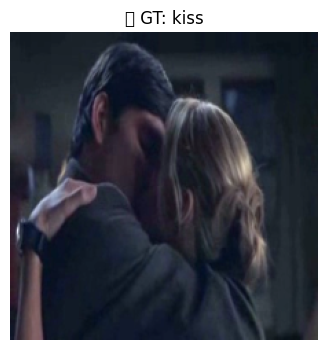

🔮 Top-5 predictions:
kiss                 | Prob: 0.9968
hug                  | Prob: 0.0031
smoke                | Prob: 0.0001
sword_exercise       | Prob: 0.0000
sword                | Prob: 0.0000
----------------------------------------


In [ ]:
show_predictions_for_class_full(model, test_loader, target_class="kiss",
                                index_to_label=index_to_label, label_to_index=label_to_index)


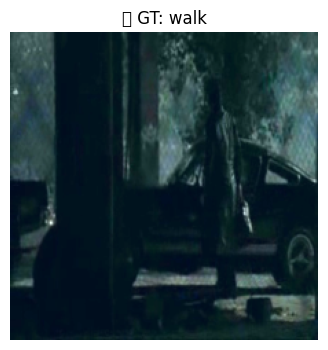

🔮 Top-5 predictions:
walk                 | Prob: 0.7021
sit                  | Prob: 0.1301
stand                | Prob: 0.1067
run                  | Prob: 0.0458
pick                 | Prob: 0.0036
----------------------------------------


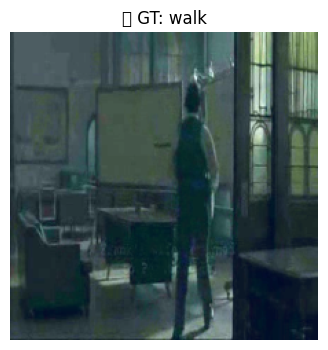

🔮 Top-5 predictions:
walk                 | Prob: 0.9988
stand                | Prob: 0.0007
run                  | Prob: 0.0002
sit                  | Prob: 0.0001
turn                 | Prob: 0.0001
----------------------------------------


In [ ]:
show_predictions_for_class_full(model, test_loader, target_class="walk",
                                index_to_label=index_to_label, label_to_index=label_to_index)
